# Noisy quantum device simulation with QuTiP

Following: https://nbviewer.jupyter.org/github/qutip/qutip-notebooks/blob/master/examples/qip-noisy-device-simulator.ipynb

From the [QuTiP Tutorials](http://qutip.org/tutorials.html).

The basic element is a control pulse characterized by a driving Hamiltonian, the target qubits, and the pulse time sequence and amplitudes. Based on pulse level control, different backends may be defined for different physical systems (e.g., cavity QED, ion traps, or circuit QED, etc.). A compiler needs to be defined for each backend. The `Processor` translates a quantum circuit into the control pulse sequence and performs a (noisy) simulation.

## Pulse level control

In [1]:
import copy
import numpy as np
import matplotlib.pyplot as plt
pi = np.pi

from qutip.qip.device import Processor
from qutip.operators import sigmaz, sigmay, sigmax, destroy
from qutip.states import basis
from qutip.metrics import fidelity
from qutip.qip.operations import rx, ry, rz, hadamard_transform

### Controlling a single qubit

Each pulse is represented by a `Pulse` object consisting of the control Hamiltonian, the target qubits, the pulse strength and the time sequence $t$. The evolution is given by:

$$
U(t) = \exp\left( -i \sum_j c_j\left(t\right) H_j t \right)
$$

Here we define a single-qubit quantum device with $\sigma_z$ and $\sigma_y$ pulses:

In [2]:
processor = Processor(N=1)
processor.add_control(0.5 * sigmaz(), targets=0, label='sigmaz')
processor.add_control(0.5 * sigmay(), targets=0, label='sigmay')

The list of defined pulses are saved in the `.pulses` attribute:

In [3]:
for pulse in processor.pulses:
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------
----------------------------------------------------------------------
Pulse label: sigmay
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------


To characterize evolution we need to define the `tlist` and `coeff` terms. These are given as NumPy arrays. `tlist` specifies the start and end for each pulse coefficient (for discrete pulses), so it is one element longer than `coeff`.

Let's turn on the $\sigma_y$ pulse for $t = \pi$ with strength 1.

(Notice $H = \frac{1}{2} \sigma_z$ ??)

In [4]:
processor.pulses[1].coeff = np.array([1.])
processor.pulses[1].tlist = np.array([0., pi])
for pulse in processor.pulses:
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': None, 'coeff': None}
----------------------------------------------------------------------
----------------------------------------------------------------------
Pulse label: sigmay
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]], 'targets': [0], 'tlist': array([0.        , 3.14159265]), 'coeff': array([1.])}
----------------------------------------------------------------------


This pulse is a $\pi$ pulse that flips the qubit from $|0\rangle$ to $|1\rangle$, equivalent to a rotation around the $y$-axis of $\pi$.

$$
R_y\left(\theta\right) = \begin{pmatrix} \cos \theta/2 & -\sin \theta / 2 \\ \sin \theta / 2 & \cos \theta / 2 \end{pmatrix}
$$

We may run the simulation to see the result of the evolution starting in $|0\rangle$:

In [5]:
basis0 = basis(2, 0)
result = processor.run_state(init_state=basis0)

In [6]:
result.states[-1].tidyup(1.e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [7]:
basis0

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[1.]
 [0.]]

Testing a different set of pulses...

In [8]:
processor.pulses[1].coeff = np.array([1.])
processor.pulses[1].tlist = np.array([0., pi / 2])
result = processor.run_state(init_state=basis0)
result.states[-1].tidyup(1.e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710797]
 [0.70710559]]

In [9]:
processor.pulses[1].coeff = np.array([.5])
processor.pulses[1].tlist = np.array([0., pi])
result = processor.run_state(init_state=basis0)
result.states[-1].tidyup(1.e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.70710797]
 [0.70710559]]

In [10]:
processor.pulses[1].coeff = np.array([.5])
processor.pulses[1].tlist = np.array([0., pi / 2])
result = processor.run_state(init_state=basis0)
result.states[-1].tidyup(1.e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.92387955]
 [0.38268338]]

In [11]:
processor.pulses[1].coeff = np.array([.5])
processor.pulses[1].tlist = np.array([0., 2 * pi])
result = processor.run_state(init_state=basis0)
result.states[-1].tidyup(1.e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

Any single qubit gate may be decomposed into $R_z(\theta_1) \cdot R_y(\theta_2) \cdot R_z(\theta_3)$, so it is sufficient to use three pulses. For example:

In [12]:
processor.pulses[0].coeff = np.array([1., 0., 1.])
processor.pulses[1].coeff = np.array([0., 1., 0.])
processor.pulses[0].tlist = np.array([0., pi/2., 2*pi/2., 3*pi/2.])
processor.pulses[1].tlist = np.array([0., pi/2., 2*pi/2., 3*pi/2.])

In [13]:
result = processor.run_state(init_state=basis(2, 1))
result.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

### Pulse with continuous amplitude

If the pulse strength is generated elsewhere and is a discretization of a continuous function, we can tell the `Processor` to use them with cubic spline interpolation. In this case, `tlist` and `coeff` must have the same length.

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd848597510>)

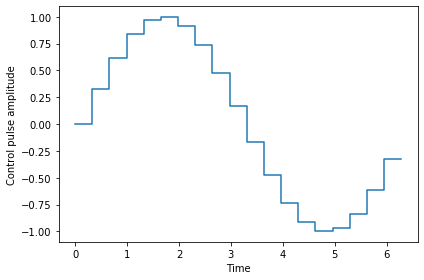

In [14]:
tlist = np.linspace(0., 2 * pi, 20)
processor = Processor(N=1, spline_kind='step_func')
processor.add_control(sigmaz(), 0)
processor.pulses[0].tlist = tlist
processor.pulses[0].coeff = np.array([np.sin(t) for t in tlist])
processor.plot_pulses()

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd8289f6d10>)

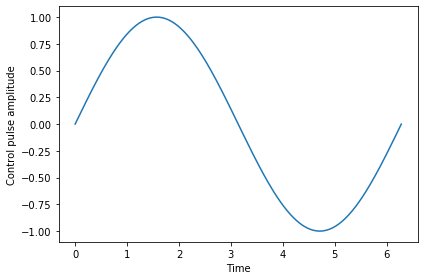

In [15]:
tlist = np.linspace(0., 2 * pi, 20)
processor = Processor(N=1, spline_kind='cubic')
processor.add_control(sigmaz(), 0)
processor.pulses[0].tlist = tlist
processor.pulses[0].coeff = np.array([np.sin(t) for t in tlist])
processor.plot_pulses()

## Noisy evolution

Generally, there are two types of noise - coherent and incoherent. The former usually comes from deviations in the control pulse. This sort of noisy evolution is still unitary. Incoherent noise comes from coupling to the environment and leads to true information loss. In QIS theory, we describe this sort of noise with a "noisy channel," corresponding to the collapse operators in the Lindblad equation.

The `Processor` simulates the evolution of qubits under the driving Hamiltonian and noise will be defined according to the control pulses, with evolution computed using the QuTiP solvers. This enables a complex noise description (including, e.g. cross-talk and leakages). This simulation can help identify dominant noise sources and is useful for studying algorithm sensitivity to noise.

### Decoherence

Decoherence is simulated in the `Processor` by adding a collapse operator into the Lindbladian equation. For single-qubit decoherence it is equivalent to applying random flip and phase flip errors after applying the quantum gate. For qubit relaxation, one can specify the $t_1$ and $t_2$ time for the device for each qubit. For example, with a drift Hamiltonian of $H_d = \hbar \omega \sigma_z$ with $\hbar \omega = 10$:

In [25]:
a = destroy(2)
initial_state = basis(2, 1)
plus_state = (basis(2, 1) + basis(2, 0)).unit()
tlist = np.arange(0.0, 2.02, 0.02)
H_d = 10. * sigmaz()   # don't use this for anything here?

#### Decay time $T_1$

The $T_1$ relaxation time describes the amplitude damping strength. In a two-level system we use a collapse operator $\frac{1}{\sqrt{T_1}} a$, where $a$ is the annihilation operator.

This leads to exponential decay of the population of excited states proportional to $\exp(-t / T_1)$.

In [26]:
from qutip.qip.pulse import Pulse

In [27]:
t1 = 1.
processor = Processor(1, t1=t1)
# dummy pulse with no Hamiltonian but only a tlist
processor.add_pulse(Pulse(None, None, tlist=tlist, coeff=False))

In [28]:
initial_state

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [29]:
a.dag() * a

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0. 0.]
 [0. 1.]]

In [30]:
a.dag() * a * initial_state

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [1.]]

In [31]:
a.dag() * a * basis(2, 0)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[0.]
 [0.]]

In [32]:
result = processor.run_state(init_state=initial_state,
                            e_ops=[a.dag() * a])

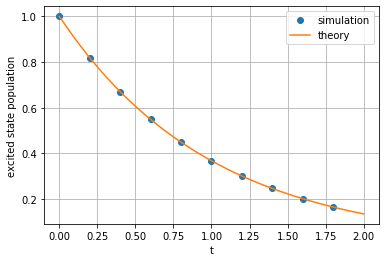

In [33]:
fig, ax = plt.subplots()
ax.plot(tlist[0: 100: 10],
        result.expect[0][0: 100: 10],
        'o', label='simulation')
ax.plot(tlist, np.exp(-1. / t1 * tlist), label='theory')
ax.set_xlabel('t')
ax.set_ylabel('excited state population')
ax.legend()
plt.grid()

#### Decay time $T_2$

$T_2$ describes the dephasing process. We must be careful that the amplitdue damping channel characterized by $T_1$ will also lead to a dephasing proportional to $\exp(-t / 2 T_1)$. To ensure the overall phase damping is $\exp(-t / T_2)$, the processor uses a collapse operator $\frac{1}{2 T_{2}'} \sigma_z$ with 

$$
\frac{1}{T_{2}} = \frac{1}{T_{2}'} + \frac{1}{2 T_1}
$$

to simulate dephasing. This implies $T_2 \leq 2 T_1$.

$T_2$ is usually measured by the Ramsey experiment, where the qubit starts in the excited state, undergoes a $\pi / 2$ pulse, proceeds for a time $t$, and is then measured after another $\pi / 2$ pulse. For simplicity, here we directly calculate the expectaion value of $H \cdot a^{\dagger}a \cdot H$, where $H$ denotes the Hadamard. This is the same as a measure of the population $\frac{1}{\sqrt{2}} \left(|0\rangle + |1\rangle \right)$.

The envelope should follow an expontential decay characterized by $T_2$:

In [34]:
H_d   # 10 * sigmaz

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 10.   0.]
 [  0. -10.]]

In [35]:
t1 = 1.
t2 = 0.5
processor = Processor(1, t1=t1, t2=t2)
processor.add_control(H_d, 0)
processor.pulses[0].coeff = True
processor.pulses[0].tlist = tlist
Hadamard = hadamard_transform(1)
result = processor.run_state(init_state=plus_state,
                            e_ops=[Hadamard * a.dag() * a * Hadamard])

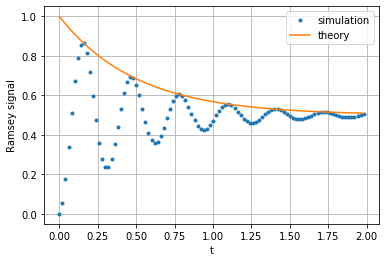

In [36]:
fig, ax = plt.subplots()
ax.plot(tlist[:-1], result.expect[0][:-1], '.',
        label='simulation')
ax.plot(tlist[:-1], np.exp(-1./t2*tlist[:-1]) * 0.5 + 0.5,
        label='theory')
plt.xlabel('t')
plt.ylabel('Ramsey signal')
plt.legend()
ax.grid()

### Random noise in the pulse intensity

`Processor` can also simulate coherent control noise. One may define a noise object and add it to the processor to simulate general types of noise. One example of predefined noise is random amplitude noise, where random values are added the pulse every `dt`. `loc` and `scale` are keyword arguments for the random number generator (`np.random.normal`).

In [37]:
from qutip.qip.noise import RandomNoise

In [38]:
processor = Processor(N=1)
processor.add_control(0.5 * sigmaz(), targets=0, label='sigmaz')
processor.add_control(0.5 * sigmay(), targets=0, label='sigmay')
processor.coeffs = np.array([[1., 0., 1.],
                             [0., 1., 0.]])
processor.set_all_tlist(np.array([0., pi / 2, 2 * pi / 2, 3 * pi / 2]))
processor_white = copy.deepcopy(processor)
processor_white.add_noise(RandomNoise(rand_gen=np.random.normal, 
                                      dt=0.1, 
                                      loc=-0.05,
                                      scale=0.02))

Compare with and without noise:

In [39]:
result = processor.run_state(init_state=basis(2, 1))
result.states[-1].tidyup(1.0e-5)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.7071043+0.j        ]
 [ 0.       +0.70710926j]]

In [40]:
result_white = processor_white.run_state(init_state=basis(2, 1))
result_white.states[-1].tidyup(1.0e-4)

Quantum object: dims = [[2], [1]], shape = (2, 1), type = ket
Qobj data =
[[-0.63432494+0.00337478j]
 [ 0.12417874+0.7630204j ]]

In [41]:
fidelity(result.states[-1], result_white.states[-1])

0.99218074290591

Since the result of this noise is still a pure we state, we can visualize it on the Bloch sphere:

In [42]:
from qutip.bloch import Bloch

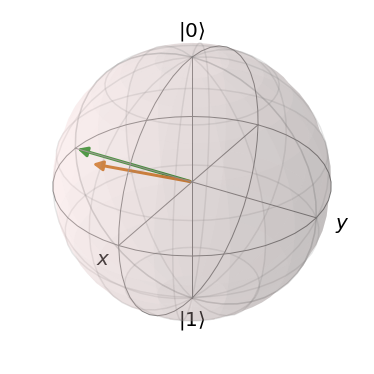

In [43]:
b = Bloch()
b.add_states([result.states[-1], result_white.states[-1]])
b.make_sphere()

We can print the pulses to see the noise. First, the ideal:

In [44]:
for pulse in processor_white.pulses:
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': array([0.        , 1.57079633, 3.14159265, 4.71238898]), 'coeff': array([1., 0., 1.])}
----------------------------------------------------------------------
----------------------------------------------------------------------
Pulse label: sigmay
The pulse contains: 0 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[0.+0.j  0.-0.5j]
 [0.+0.5j 0.+0.j ]], 'targets': [0], 'tlist': array([0.        , 1.57079633, 3.14159265, 4.71238898]), 'coeff': array([0., 1., 0.])}
----------------------------------------------------------------------


Now, the noisy:

In [45]:
for pulse in processor_white.get_noisy_pulses():
    pulse.print_info()

----------------------------------------------------------------------
Pulse label: sigmaz
The pulse contains: 1 coherent noise elements and 0 Lindblad noise elements.

Ideal pulse:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': array([0.        , 1.57079633, 3.14159265, 4.71238898]), 'coeff': array([1., 0., 1.])}

Coherent noise:
{'qobj': Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = True
Qobj data =
[[ 0.5  0. ]
 [ 0.  -0.5]], 'targets': [0], 'tlist': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9, 4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7]), 'coeff': array([-0.03100122, -0.04205694, -0.04640997, -0.04568998, -0.04128108,
       -0.07032925, -0.04593738, -0.08644839, -0.05125383, 

## Getting a `Pulse` or `QobjEvo` representation

If we define a complicated `Processor`, but don't want to run the simulation right now, we can extract an ideal/noisy `Pulse` representation or `QobjEvo` representation. The latter one can be fed directly to QuTiP's solver to compute the evolution:

In [46]:
ideal_pulses = processor_white.pulses
noisy_pulses = processor_white.get_noisy_pulses(
    device_noise=True, drift=True)

In [47]:
qobjevo = processor_white.get_qobjevo(noisy=False)
noisy_qobjevo, c_ops = processor_white.get_qobjevo(noisy=True)

In [48]:
qobjevo

(<qutip.qobjevo.QobjEvo at 0x7fd848a5bc50>, [])

In [49]:
noisy_qobjevo

In [50]:
c_ops

[]